# Importing Required Libraries
In this section, we import all required Python libraries for data handling, model training, evaluation, and MLflow experiment tracking.

In [36]:
# Imports
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, recall_score, classification_report, precision_score, f1_score
import xgboost as xgb

import mlflow
import mlflow.xgboost
from mlflow.tracking import MlflowClient


# DATA LOADING & INSPECTION
## Load pre-cleaned telecom churn data (all features numeric, target = 'Customer Status')

In [39]:
df = pd.read_csv('telecom_customer_churn_clean.csv')
df.head()

,Gender,Age,Married,Number of Dependents,City_0,City_1,City_2,City_3,City_4,City_5,...,Streaming TV,Streaming Movies,Streaming Music,Unlimited Data,Contract,Total Charges,Total Refunds,Total Extra Data Charges,Total Long Distance Charges,Customer Status
0,0,37,1,0,0,0,0,0,0,0,...,1,0,0,1,2,593.30,0.00,0,381.51,0
1,1,46,0,0,0,0,0,0,0,0,...,0,1,1,0,1,542.40,38.33,10,96.21,0
2,1,50,0,0,0,0,0,0,0,0,...,0,0,0,1,1,280.85,0.00,0,134.60,1
3,1,78,1,0,0,0,0,0,0,0,...,1,1,0,1,1,1237.85,0.00,0,361.66,1
4,0,75,1,0,0,0,0,0,0,0,...,1,0,0,1,1,267.40,0.00,0,22.14,1


## Findings:
 - Shape: (7043, 22)
 - Target: 'Customer Status' (0 = No Churn, 1 = Churn)
 - Churn rate: ~27% 
 - All features are numeric 

## Preparing Features (X) and Target (y)  
We separate the independent variables (X) from the target variable (y), where `Customer Status` indicates whether the customer churned.

In [43]:
X = df.drop(columns=['Customer Status'])
y = df['Customer Status']

## Splitting the Data (Train/Test Split)
 - Split Before any preprocessing to avoid data leakage
 - We use an 80/20 train-test split with stratification to maintain the same churn ratio in both sets.

In [46]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=42, stratify=y)

## FEATURE SCALING 

### Why scale? 
 - While XGBoost is tree-based and *technically* doesn’t require scaling,
 - we apply it for fair comparison with teammates using models that do (e.g., Logistic Regression, SVM).

In [49]:
scaler = StandardScaler()

# Fit scaler ONLY on training data → prevents data leakage
X_train_scaled = scaler.fit_transform(X_train)

# Transform test data using TRAINING stats (mean, std)
X_test_scaled = scaler.transform(X_test)

print("Feature Scaling Applied (StandardScaler)")


Feature Scaling Applied (StandardScaler)


## Initialize MLflow
We configure MLflow to track experiments, models, parameters, and performance metrics.  

In [54]:
mlflow.set_tracking_uri("http://127.0.0.1:5000")
mlflow.set_experiment("XGBoost")
client = MlflowClient()
MODEL_NAME = "Churn_XGBoost"

# MODEL: XGBoost Classifier

## Why XGBoost?
 - State-of-the-art gradient boosting → typically outperforms sklearn's GradientBoosting
 - Built-in handling of class imbalance via `scale_pos_weight`
 - Regularization built-in (reduces overfitting)
 - Used in most Kaggle competitions for tabular data


## PART 1: Baseline Model (Default Parameters)

In [58]:
with mlflow.start_run(run_name="Baseline_Default") as run1:
    # Compute scale_pos_weight for class imbalance handling
    # Formula: weight = num_negative / num_positive
    scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])
    
    # Build model
    model_baseline = xgb.XGBClassifier(
        scale_pos_weight=scale_pos_weight,  # handles imbalance safely
        random_state=42,
        use_label_encoder=False,   # suppress warning
        eval_metric='logloss'      # standard for binary classification
    )
    
    # Train on scaled data
    model_baseline.fit(X_train_scaled, y_train)
    
    # Predict on test
    y_pred_baseline = model_baseline.predict(X_test_scaled)
    
    # Evaluate
    acc_baseline = accuracy_score(y_test, y_pred_baseline)
    rec_baseline = recall_score(y_test, y_pred_baseline)  
    precision = precision_score(y_test, y_pred_baseline, average="weighted")
    f1 = f1_score(y_test, y_pred_baseline, average="weighted")
    
    # Log to MLflow
    mlflow.log_param("approach", "baseline_default")
    mlflow.log_param("scale_pos_weight", scale_pos_weight)
    mlflow.log_params(model_baseline.get_params())
    mlflow.log_metric("test_accuracy", acc_baseline)
    mlflow.log_metric("test_recall_churn", rec_baseline)
    mlflow.log_metric("precision", precision)
    mlflow.log_metric("f1_score", f1)
    mlflow.xgboost.log_model(model_baseline, "baseline_model")
    
    # Register model
    model_uri = f"runs:/{run1.info.run_id}/baseline_model"
    reg_result = mlflow.register_model(model_uri, MODEL_NAME)
    client.set_registered_model_alias(MODEL_NAME, "baseline", reg_result.version)
    
    print(f"Baseline Results:\n")
    print(f"scale_pos_weight: {scale_pos_weight: 0.2f}")
    print(f"Test Accuracy: {acc_baseline: 0.2%}")
    print(f"Test Recall (Churn): {rec_baseline: 0.2%}")
    print(f"Precision: {precision:0.2%}")
    print(f"F1 Score: {f1:0.2%}")

C:\Users\DELL\anaconda3\Lib\site-packages\xgboost\training.py:199: UserWarning: [18:30:01] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
2025/12/09 18:30:01 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
C:\Users\DELL\anaconda3\Lib\site-packages\xgboost\sklearn.py:1116: UserWarning: [18:30:02] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\c_api\c_api.cc:1575: Saving model in the UBJSON format as default.  You can use a file extension: `json` or `ubj` to choose between formats.
  self.get_booster().save_model(fname)
2025/12/09 18:30:26 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Registered model 'Churn_XGBoost' already exists. Creating a new version of this model...
2025/12/09 18:30:28 WARNING 

Baseline Results:

scale_pos_weight:  2.53
Test Accuracy:  84.45%
Test Recall (Churn):  71.66%
Precision: 84.36%
F1 Score: 84.40%
🏃 View run Baseline_Default at: http://127.0.0.1:5000/#/experiments/732617381284536529/runs/cab075e44cb8423a9b08b855a1a66354
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/732617381284536529


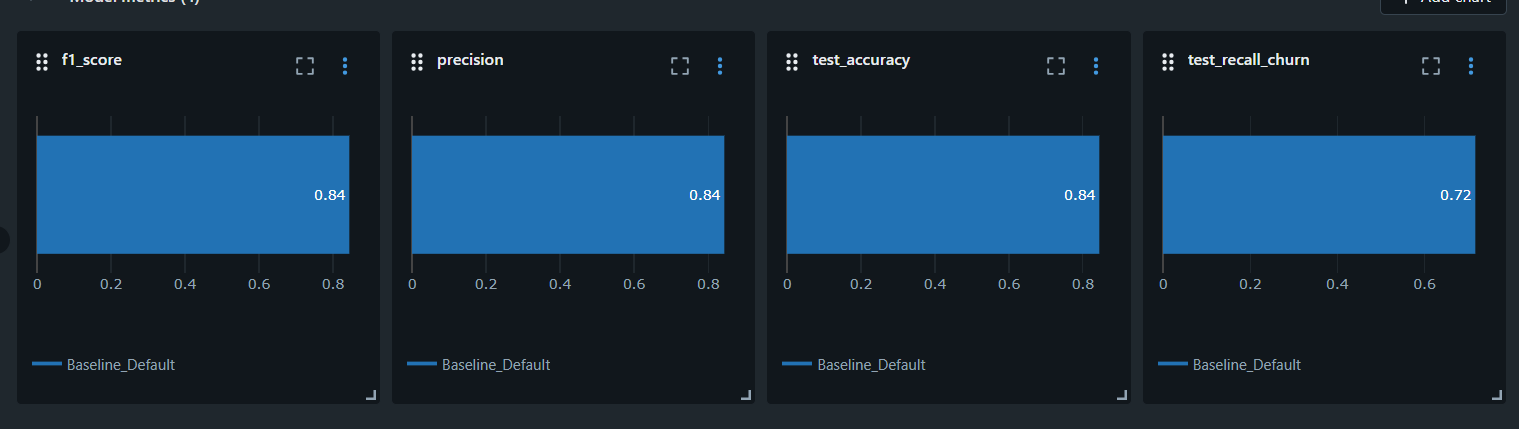

## PART 2: Tuned Model (GridSearchCV — Optimized for Recall)
### Define hyperparameter grid
#### Key parameters:
   - learning_rate: smaller → more robust
   - max_depth: controls model complexity
   - subsample/colsample_bytree: stochastic regularization
   - scale_pos_weight: fixed from baseline (computed on train set)

In [61]:
param_grid = {
    'learning_rate': [0.01, 0.02, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'n_estimators': [100, 150, 200, 250],
    'subsample': [0.8, 0.85, 0.9, 0.095],
    'colsample_bytree': [0.8, 0.9]
}

with mlflow.start_run(run_name="Tuned_GridSearch") as run2:
    # Fix scale_pos_weight (computed once on train set)
    scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])
    
    # Build base model with fixed scale_pos_weight
    base_model = xgb.XGBClassifier(
        scale_pos_weight=scale_pos_weight,
        random_state=42,
        use_label_encoder=False,
        eval_metric='logloss'
    )
    
    # GridSearchCV (CV on Train only → no leakage)
    grid = GridSearchCV(
        estimator=base_model,
        param_grid=param_grid,
        cv=3,
        scoring='recall',   # Optimize for churn recall
        n_jobs=-1,
        verbose=0
    )
    
    # Fit on scaled Train data
    grid.fit(X_train_scaled, y_train)
    
    # Best model
    best_model = grid.best_estimator_
    
    # Predict on Test
    y_pred_tuned = best_model.predict(X_test_scaled)
    
    # Evaluate
    acc_tuned = accuracy_score(y_test, y_pred_tuned)
    rec_tuned = recall_score(y_test, y_pred_tuned)
    precision = precision_score(y_test, y_pred_tuned, average="weighted")
    f1 = f1_score(y_test, y_pred_tuned, average="weighted")
    
    # Log to MLflow
    mlflow.log_param("approach", "tuned_gridsearch")
    mlflow.log_param("scale_pos_weight", scale_pos_weight)
    mlflow.log_params(grid.best_params_)
    mlflow.log_metric("cv_best_recall", grid.best_score_)
    mlflow.log_metric("test_accuracy", acc_tuned)
    mlflow.log_metric("test_recall_churn", rec_tuned)
    mlflow.log_metric("precision", precision)
    mlflow.log_metric("f1_score", f1)
    mlflow.xgboost.log_model(best_model, "tuned_model")
    
    # Register tuned model
    model_uri = f"runs:/{run2.info.run_id}/tuned_model"
    reg_result = mlflow.register_model(model_uri, MODEL_NAME)
    client.set_registered_model_alias(MODEL_NAME, "tuned", reg_result.version)
    
    print(f"Tuned Model Results:\n")
    print(f"scale_pos_weight: {scale_pos_weight: 0.2f}")
    print(f"Best CV Recall: {grid.best_score_: 0.2%}")
    print(f"Test Accuracy:  {acc_tuned: 0.2%}")
    print(f"Test Recall (Churn): {rec_tuned: 0.2%}")
    print(f"F1 Score: {f1:0.2%}")
    print(f"\nBest params: {grid.best_params_}")

C:\Users\DELL\anaconda3\Lib\site-packages\xgboost\training.py:199: UserWarning: [18:31:59] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
2025/12/09 18:32:00 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
C:\Users\DELL\anaconda3\Lib\site-packages\xgboost\sklearn.py:1116: UserWarning: [18:32:01] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\c_api\c_api.cc:1575: Saving model in the UBJSON format as default.  You can use a file extension: `json` or `ubj` to choose between formats.
  self.get_booster().save_model(fname)
2025/12/09 18:34:02 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:\Users\DELL\AppData\Local\Temp\tmpbh0_hr5r\model, flavor: xgboost). Fall back to return ['xgboost==3.1.2']. Set logging level to DEBUG to see the full traceback. 
2025/12/09 18:34:

Tuned Model Results:

scale_pos_weight:  2.53
Best CV Recall:  87.09%
Test Accuracy:   83.16%
Test Recall (Churn):  83.96%
F1 Score: 83.69%

Best params: {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}

Best Params: {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}
🏃 View run Tuned_GridSearch at: http://127.0.0.1:5000/#/experiments/732617381284536529/runs/f80a922a15bc4950b9ce72d3314f0267
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/732617381284536529


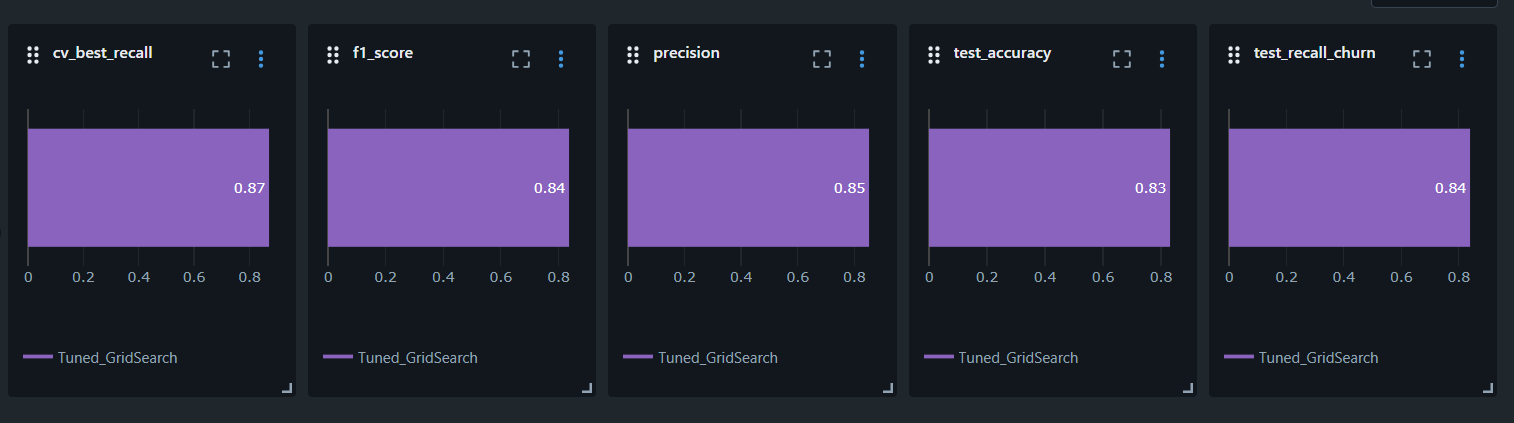